In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error
from lstm import generate_data, lstm_model, load_csvdata
from pymongo import MongoClient
from bson.objectid import ObjectId
import dateutil.parser
import datetime
import matplotlib.dates as mdates

In [2]:
LOG_DIR = './ops_logs/lstm_weather'
TIMESTEPS = 10
RNN_LAYERS = [{'num_units': 5}]
DENSE_LAYERS = [10, 10]
TRAINING_STEPS = 100000
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 100

# Transform QCLCD Data Function

In [3]:
# downloaded weather data from http://www.ncdc.noaa.gov/qclcd/QCLCD
def load_weather_frame(filename):
    #load the weather data and make a date
    data_raw = pd.read_csv(filename, dtype={'Time': str, 'Date': str})
    data_raw['WetBulbCelsius'] = data_raw['WetBulbCelsius'].astype(float)
    times = []
    for index, row in data_raw.iterrows():
        _t = datetime.time(int(row['Time'][:2]), int(row['Time'][:-2]), 0) #2153
        _d = datetime.datetime.strptime( row['Date'], "%Y%m%d" ) #20150905
        times.append(datetime.datetime.combine(_d, _t))

    data_raw['_time'] = pd.Series(times, index=data_raw.index)
    df =  pd.DataFrame(data_raw, columns=['_time','WetBulbCelsius'])
    return df.set_index('_time')


# Load The Data as CSV 
This is QCLCD data for PDX. It is waht will be used to train the model.

In [4]:
# scale values to reasonable values and convert to float
data_weather = load_weather_frame("data/QCLCD_PDX_20150901.csv")
X, y = load_csvdata(data_weather, TIMESTEPS, seperate=False)

# Run The Model and Fit Predictions

In [5]:
regressor = learn.Estimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS),
                           model_dir=LOG_DIR)

In [6]:
# create a lstm instance and validation monitor
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                     every_n_steps=PRINT_STEPS,
                                                     early_stopping_rounds=1000)
regressor.fit(X['train'], y['train'],
              monitors=[validation_monitor],
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

predicted = regressor.predict(X['test'])

Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
Please use tf.contrib.layers.stack instead.


In [7]:
#not used in this example but used for seeing deviations
rmse = np.sqrt(((predicted - y['test']) ** 2).mean(axis=0))

score = mean_squared_error(predicted, y['test'])
print ("MSE: %f" % score)

MSE: 0.441194


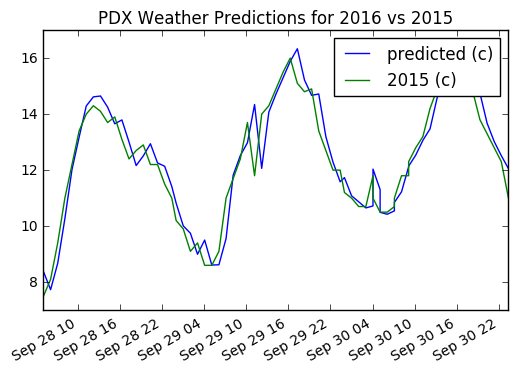

In [8]:
# plot the data
all_dates = data_weather.index.get_values()

fig, ax = plt.subplots(1)
fig.autofmt_xdate()

predicted_values = predicted.flatten() #already subset
predicted_dates = all_dates[len(all_dates)-len(predicted_values):len(all_dates)]
predicted_series = pd.Series(predicted_values, index=predicted_dates)
plot_predicted, = ax.plot(predicted_series, label='predicted (c)')

test_values = y['test'].flatten()
test_dates = all_dates[len(all_dates)-len(test_values):len(all_dates)]
test_series = pd.Series(test_values, index=test_dates)
plot_test, = ax.plot(test_series, label='2015 (c)')

xfmt = mdates.DateFormatter('%b %d %H')
ax.xaxis.set_major_formatter(xfmt)

# ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d %H')
plt.title('PDX Weather Predictions for 2016 vs 2015')
plt.legend(handles=[plot_predicted, plot_test])
plt.show()